/state/partition1/llgrid/pkg/anaconda/anaconda3-2019a/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2019-04-05 23:06:30,977 INFO STARTED running simulations


Instructions for updating:
Colocations handled automatically by placer.


2019-04-05 23:06:31,342 WARNING From /state/partition1/llgrid/pkg/anaconda/anaconda3-2019a/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
2019-04-05 23:06:31,508 INFO Processing: bl


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
dense (Dense)                (None, 32, 32, 16)        528       
__________

16/16 [==============================] - 0s 17ms/step - loss: 54.0566 - acc: 0.4742
Epoch 70/500
16/16 [==============================] - 0s 19ms/step - loss: 54.1069 - acc: 0.5205
Epoch 71/500
16/16 [==============================] - 0s 17ms/step - loss: 54.0825 - acc: 0.5221
Epoch 72/500
16/16 [==============================] - 0s 18ms/step - loss: 53.9158 - acc: 0.5220
Epoch 73/500
16/16 [==============================] - 0s 16ms/step - loss: 53.7960 - acc: 0.4178
Epoch 74/500
16/16 [==============================] - 0s 19ms/step - loss: 53.7979 - acc: 0.5221
Epoch 75/500
16/16 [==============================] - 0s 17ms/step - loss: 54.3057 - acc: 0.5200
Epoch 76/500
16/16 [==============================] - 0s 18ms/step - loss: 53.9134 - acc: 0.5222
Epoch 77/500
16/16 [==============================] - 0s 17ms/step - loss: 54.0002 - acc: 0.5217
Epoch 78/500
16/16 [==============================] - 0s 17ms/step - loss: 53.6553 - acc: 0.5218
Epoch 79/500
16/16 [=======================

16/16 [==============================] - 0s 17ms/step - loss: 53.5749 - acc: 0.5053
Epoch 154/500
16/16 [==============================] - 0s 17ms/step - loss: 53.5834 - acc: 0.4733
Epoch 155/500
16/16 [==============================] - 0s 19ms/step - loss: 53.2761 - acc: 0.5083
Epoch 156/500
16/16 [==============================] - 0s 17ms/step - loss: 53.6273 - acc: 0.5148
Epoch 157/500
16/16 [==============================] - 0s 18ms/step - loss: 53.3692 - acc: 0.4743
Epoch 158/500
16/16 [==============================] - 0s 17ms/step - loss: 53.2320 - acc: 0.5140
Epoch 159/500
16/16 [==============================] - 0s 18ms/step - loss: 53.4139 - acc: 0.4871
Epoch 160/500
16/16 [==============================] - 0s 17ms/step - loss: 53.2629 - acc: 0.5024
Epoch 161/500
16/16 [==============================] - 0s 18ms/step - loss: 53.3058 - acc: 0.5068
Epoch 162/500
16/16 [==============================] - 0s 18ms/step - loss: 53.4966 - acc: 0.5008
Epoch 163/500
16/16 [=============

16/16 [==============================] - 0s 18ms/step - loss: 53.3226 - acc: 0.4911
Epoch 237/500
16/16 [==============================] - 0s 18ms/step - loss: 52.9996 - acc: 0.4943
Epoch 238/500
16/16 [==============================] - 0s 17ms/step - loss: 53.0701 - acc: 0.4882
Epoch 239/500
16/16 [==============================] - 0s 17ms/step - loss: 53.1677 - acc: 0.4893
Epoch 240/500
16/16 [==============================] - 0s 18ms/step - loss: 53.0613 - acc: 0.4972
Epoch 241/500
16/16 [==============================] - 0s 18ms/step - loss: 52.7885 - acc: 0.4997
Epoch 242/500
16/16 [==============================] - 0s 18ms/step - loss: 52.9580 - acc: 0.4962
Epoch 243/500
16/16 [==============================] - 0s 18ms/step - loss: 52.8513 - acc: 0.4880
Epoch 244/500
16/16 [==============================] - 0s 18ms/step - loss: 52.7014 - acc: 0.4965
Epoch 245/500
16/16 [==============================] - 0s 18ms/step - loss: 52.9109 - acc: 0.4997
Epoch 246/500
16/16 [=============

16/16 [==============================] - 0s 18ms/step - loss: 53.0647 - acc: 0.4846
Epoch 320/500
16/16 [==============================] - 0s 17ms/step - loss: 52.6847 - acc: 0.4908
Epoch 321/500
16/16 [==============================] - 0s 18ms/step - loss: 52.4727 - acc: 0.4978
Epoch 322/500
16/16 [==============================] - 0s 17ms/step - loss: 52.5630 - acc: 0.4925
Epoch 323/500
16/16 [==============================] - 0s 17ms/step - loss: 52.5311 - acc: 0.4900
Epoch 324/500
16/16 [==============================] - 0s 17ms/step - loss: 52.4707 - acc: 0.4932
Epoch 325/500
16/16 [==============================] - 0s 17ms/step - loss: 52.6959 - acc: 0.4909
Epoch 326/500
16/16 [==============================] - 0s 17ms/step - loss: 52.4438 - acc: 0.4880
Epoch 327/500
16/16 [==============================] - 0s 18ms/step - loss: 52.5353 - acc: 0.4921
Epoch 328/500
16/16 [==============================] - 0s 19ms/step - loss: 52.7243 - acc: 0.4796
Epoch 329/500
16/16 [=============

16/16 [==============================] - 0s 18ms/step - loss: 52.4218 - acc: 0.4970
Epoch 403/500
16/16 [==============================] - 0s 17ms/step - loss: 52.3507 - acc: 0.4811
Epoch 404/500
16/16 [==============================] - 0s 17ms/step - loss: 52.2679 - acc: 0.4970
Epoch 405/500
16/16 [==============================] - 0s 18ms/step - loss: 52.1680 - acc: 0.4816
Epoch 406/500
16/16 [==============================] - 0s 18ms/step - loss: 52.1206 - acc: 0.4916
Epoch 407/500
16/16 [==============================] - 0s 17ms/step - loss: 52.3860 - acc: 0.4365
Epoch 408/500
16/16 [==============================] - 0s 18ms/step - loss: 52.2041 - acc: 0.5014
Epoch 409/500
16/16 [==============================] - 0s 18ms/step - loss: 52.2087 - acc: 0.4892
Epoch 410/500
16/16 [==============================] - 0s 18ms/step - loss: 52.2913 - acc: 0.4657
Epoch 411/500
16/16 [==============================] - 0s 17ms/step - loss: 52.3146 - acc: 0.4928
Epoch 412/500
16/16 [=============

16/16 [==============================] - 0s 17ms/step - loss: 51.8736 - acc: 0.4751
Epoch 486/500
16/16 [==============================] - 0s 18ms/step - loss: 51.9597 - acc: 0.4743
Epoch 487/500
16/16 [==============================] - 0s 17ms/step - loss: 52.1866 - acc: 0.4773
Epoch 488/500
16/16 [==============================] - 0s 18ms/step - loss: 52.0229 - acc: 0.4934
Epoch 489/500
16/16 [==============================] - 0s 17ms/step - loss: 52.0958 - acc: 0.4691
Epoch 490/500
16/16 [==============================] - 0s 18ms/step - loss: 52.2222 - acc: 0.4845
Epoch 491/500
16/16 [==============================] - 0s 17ms/step - loss: 52.1037 - acc: 0.4797
Epoch 492/500
16/16 [==============================] - 0s 17ms/step - loss: 52.2128 - acc: 0.4900
Epoch 493/500
16/16 [==============================] - 0s 17ms/step - loss: 52.1133 - acc: 0.4898
Epoch 494/500
16/16 [==============================] - 0s 19ms/step - loss: 51.9257 - acc: 0.4808
Epoch 495/500
16/16 [=============

2019-04-05 23:08:56,306 DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/state/partition1/llgrid/pkg/anaconda/anaconda3-2019a/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2019-04-05 23:08:56,332 DEBUG findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/state/partition1/llgrid/pkg/anaconda/anaconda3-2019a/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


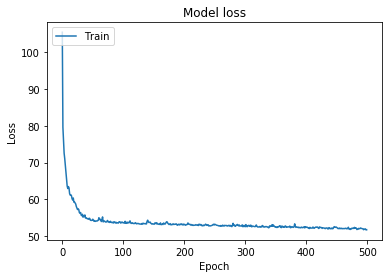

2019-04-05 23:08:56,567 DEBUG prediction output shape: (500, 32, 32, 3)
2019-04-05 23:08:56,797 INFO Processing: bl_cd


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
dense_3 (Dense)              (None, 32, 32, 16)        528       
__________

16/16 [==============================] - 0s 17ms/step - loss: 20.2953 - acc: 0.6021
Epoch 70/500
16/16 [==============================] - 0s 18ms/step - loss: 20.1165 - acc: 0.4829
Epoch 71/500
16/16 [==============================] - 0s 19ms/step - loss: 20.3501 - acc: 0.5496
Epoch 72/500
16/16 [==============================] - 0s 17ms/step - loss: 20.7833 - acc: 0.6076
Epoch 73/500
16/16 [==============================] - 0s 18ms/step - loss: 20.8501 - acc: 0.6968
Epoch 74/500
16/16 [==============================] - 0s 18ms/step - loss: 19.9453 - acc: 0.4811
Epoch 75/500
16/16 [==============================] - ETA: 0s - loss: 19.8745 - acc: 0.49 - 0s 18ms/step - loss: 20.0717 - acc: 0.5380
Epoch 76/500
16/16 [==============================] - 0s 18ms/step - loss: 20.2961 - acc: 0.5195
Epoch 77/500
16/16 [==============================] - 0s 17ms/step - loss: 20.0825 - acc: 0.4041
Epoch 78/500
16/16 [==============================] - 0s 18ms/step - loss: 20.1062 - acc: 0.5049
Epoch

16/16 [==============================] - 0s 18ms/step - loss: 20.1023 - acc: 0.5186
Epoch 153/500
16/16 [==============================] - 0s 18ms/step - loss: 19.9931 - acc: 0.4871
Epoch 154/500
16/16 [==============================] - 0s 19ms/step - loss: 19.7447 - acc: 0.3681
Epoch 155/500
16/16 [==============================] - 0s 18ms/step - loss: 19.7507 - acc: 0.3508
Epoch 156/500
16/16 [==============================] - 0s 18ms/step - loss: 19.8941 - acc: 0.6330
Epoch 157/500
16/16 [==============================] - 0s 17ms/step - loss: 20.0178 - acc: 0.7053
Epoch 158/500
16/16 [==============================] - 0s 18ms/step - loss: 20.1704 - acc: 0.5420
Epoch 159/500
16/16 [==============================] - 0s 19ms/step - loss: 19.6048 - acc: 0.4197
Epoch 160/500
16/16 [==============================] - 0s 17ms/step - loss: 19.6529 - acc: 0.5725
Epoch 161/500
16/16 [==============================] - 0s 18ms/step - loss: 19.7656 - acc: 0.4680
Epoch 162/500
16/16 [=============

16/16 [==============================] - 0s 17ms/step - loss: 19.7733 - acc: 0.4191
Epoch 236/500
16/16 [==============================] - 0s 18ms/step - loss: 19.7527 - acc: 0.4653
Epoch 237/500
16/16 [==============================] - 0s 17ms/step - loss: 19.7993 - acc: 0.4318
Epoch 238/500
16/16 [==============================] - 0s 18ms/step - loss: 19.6148 - acc: 0.5172
Epoch 239/500
16/16 [==============================] - 0s 18ms/step - loss: 19.5823 - acc: 0.5328
Epoch 240/500
16/16 [==============================] - 0s 18ms/step - loss: 19.6263 - acc: 0.5664
Epoch 241/500
16/16 [==============================] - 0s 18ms/step - loss: 19.5555 - acc: 0.4488
Epoch 242/500
16/16 [==============================] - 0s 17ms/step - loss: 19.9509 - acc: 0.5097
Epoch 243/500
16/16 [==============================] - 0s 19ms/step - loss: 19.8093 - acc: 0.5779
Epoch 244/500
16/16 [==============================] - 0s 17ms/step - loss: 19.5866 - acc: 0.3834
Epoch 245/500
16/16 [=============

16/16 [==============================] - 0s 18ms/step - loss: 19.5080 - acc: 0.4353
Epoch 319/500
16/16 [==============================] - 0s 19ms/step - loss: 19.7808 - acc: 0.6987
Epoch 320/500
16/16 [==============================] - 0s 18ms/step - loss: 19.5910 - acc: 0.6706
Epoch 321/500
16/16 [==============================] - 0s 19ms/step - loss: 19.6529 - acc: 0.4829
Epoch 322/500
16/16 [==============================] - 0s 18ms/step - loss: 19.7928 - acc: 0.4092
Epoch 323/500
16/16 [==============================] - 0s 18ms/step - loss: 20.0140 - acc: 0.4870
Epoch 324/500
16/16 [==============================] - 0s 18ms/step - loss: 19.8019 - acc: 0.3474
Epoch 325/500
16/16 [==============================] - 0s 18ms/step - loss: 19.8533 - acc: 0.4778
Epoch 326/500
16/16 [==============================] - 0s 17ms/step - loss: 19.7056 - acc: 0.4844
Epoch 327/500
16/16 [==============================] - 0s 18ms/step - loss: 20.1889 - acc: 0.7199
Epoch 328/500
16/16 [=============

16/16 [==============================] - 0s 18ms/step - loss: 19.4406 - acc: 0.3622
Epoch 402/500
16/16 [==============================] - 0s 17ms/step - loss: 19.5859 - acc: 0.5475
Epoch 403/500
16/16 [==============================] - 0s 18ms/step - loss: 19.8360 - acc: 0.6094
Epoch 404/500
16/16 [==============================] - 0s 18ms/step - loss: 19.4233 - acc: 0.4617
Epoch 405/500
16/16 [==============================] - 0s 18ms/step - loss: 19.5734 - acc: 0.4068
Epoch 406/500
16/16 [==============================] - 0s 17ms/step - loss: 19.3664 - acc: 0.3606
Epoch 407/500
16/16 [==============================] - 0s 18ms/step - loss: 19.2572 - acc: 0.5406
Epoch 408/500
16/16 [==============================] - 0s 17ms/step - loss: 19.4721 - acc: 0.6158
Epoch 409/500
16/16 [==============================] - 0s 17ms/step - loss: 19.6979 - acc: 0.4781
Epoch 410/500
16/16 [==============================] - 0s 17ms/step - loss: 19.9017 - acc: 0.4371
Epoch 411/500
16/16 [=============

In [ ]:
%matplotlib inline


""" Training and test for model v0.2.1
This is a version which includes the augmented data. We're
using a different approach than the Sony model so we don't
have to use patching. RGB input image.
"""
import os
import logging
import pickle
from urllib.parse import urljoin

import numpy as np
import scipy.stats as sct
import tensorflow as tf
from tensorflow.train import AdamOptimizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from model02 import model02
from model_utils import enable_cloud_log, plot_images, plot_loss
from custom_loss import mean_absolute_error

logger = logging.getLogger(__name__)

# Helper functions

def read_pickle(fpath):
    with open(fpath, "rb") as infile:
        m = pickle.load(infile)
    return m

def bl(image, sample=False):
    """ Apply black level """
    
    if not np.all(sample):
        sample = [-1, -1, -1, -1, -1]  # Make sure sample isn't negative
        while not(sample[0]>0 and sample[1]>0 and sample[2]>0 and sample[3]>0 and sample[4]>0):
            sample = np.random.multivariate_normal(MEANM, COVM)
       

    BL = int(sample[0])
    image[image < BL] = BL
    image = image - BL
    
        
    return image

def bl_cd(image, sample=False):
    """ Apply black level with color distortion """

    if not np.all(sample):
        sample = [-1, -1, -1, -1, -1]   # Make sure sample isn't negative
        while not(sample[0]>0 and sample[1]>0 and sample[2]>0 and sample[3]>0 and sample[4]>0):
            sample = np.random.multivariate_normal(MEANM, COVM)
        

    image = bl(image, sample)

    WB = [ sample[1], sample[2], sample[3] ]
    
    image[... ,0] = WB[0] * image[... ,0]
    image[... ,1] = WB[1] * image[... ,1]
    image[... ,2] = WB[2] * image[... ,2]

    return image

def bl_cd_pn(image, sample=False):
    """ Apply black level with color distortion and poisson noise. """
    
    if not np.all(sample):
        sample = [-1, -1, -1, -1, -1]    # Make sure sample isn't negative
        while not(sample[0]>0 and sample[1]>0 and sample[2]>0 and sample[3]>0 and sample[4]>0):
            sample = np.random.multivariate_normal(MEANM, COVM)
        

    noise_param = 10

    image = bl_cd(image, sample)

    noise = lambda x : np.random.poisson(x / 255.0 * noise_param) / \
        noise_param * 255

    func = np.vectorize(noise)
    image = func(image)
    return image

def bl_cd_pn_ag(image, sample=False):
    """ 
    Apply black level, color distortion, poisson noise, adjust gamma. 
    """

    if not np.all(sample):
        sample = [-1, -1, -1, -1, -1]   # Make sure sample isn't negative
        while not(sample[0]>0 and sample[1]>0 and sample[2]>0 and sample[3]>0 and sample[4]>0):
            sample = np.random.multivariate_normal(MEANM, COVM)
        

    image = bl_cd_pn(image, sample)
    image = image**sample[4]
    return image


# Create checkpoint callback

checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(checkpoint_path, save_weights_only=True,
                              period=5, verbose=1)


# Retrieve latest checkpoint if it exists

def fit_model(X_train, Y_train, model, checkpoint_dir, imgtup):

    imgname, imgfunc = imgtup
    
    chk = os.listdir(checkpoint_dir)
    if len(chk) > 1:
    #    latest = tf.train.latest_checkpoint(checkpoint_dir)
    #    model.load_weights(latest)
        pass

    else:
        datagen = ImageDataGenerator(
            preprocessing_function=imgfunc)

        # Transform all training images
        datagen.fit(X_train)

        # Compile model

        learning_rate = 1e-3
        opt = AdamOptimizer(learning_rate=learning_rate)

        model.compile(optimizer=opt,
                      loss=mean_absolute_error,
                      metrics=['accuracy'])

        model.summary()

        # Fit model

        history = model.fit_generator(datagen.flow(X_train,Y_train,
                                                   batch_size=32),    
                                      steps_per_epoch=X_train.shape[0] / 32,
                                      epochs=500)
        plot_loss('review/train_val_loss_021_{}.png'.format(imgname), history)

    return model

def model_predict(model, X_test, imgtup):

    imgname, imgfunc = imgtup

    X_noise_test = imgfunc(X_test)
    output = model.predict(X_noise_test)
    
    logger.debug("prediction output shape: {}".format(output.shape))

    return output

def review_image_output(X_test, Y_pred, Y_true, imgtup, every=10):
    # Review image output

    imgname, imgfunc = imgtup
    base = "review/"

    for i in range(Y_pred.shape[0]):

        if i % every == 0:

            name = urljoin(base, 'model_pred_{}_{}.png'.format(i, imgname))
            plot_images(name, imgfunc(X_test[i,...]), Y_pred[i, ...],
                        Y_true[i,...])


def run_simulation(fcov, fmean):

    logger.info("STARTED running simulations")

    # Dataset of 50,000 32x32 color training images, 
    # labeled over 10 categories, and 10,000 test images.

    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    m = 500
    X_train = X_train[0:m,...]
    X_test = X_test[0:m,...]
    Y_train = X_train
    Y_test = X_test

    imgman = [
        ('bl', bl),
        ('bl_cd', bl_cd),
        ('bl_cd_pn', bl_cd_pn),
        ('bl_cd_pn_ag', bl_cd_pn_ag),
    ]

    for imgtup in imgman:

        # Define model    
        model = model02()

        imgname, imgfunc = imgtup
        logger.info("Processing: {}".format(imgtup[0]))
        model = fit_model(X_train, Y_test, model, checkpoint_dir, imgtup)
        Y_pred = model_predict(model, X_test, imgtup)
        review_image_output(X_test, Y_pred, Y_test, imgtup, every=50)

        model = None

    logger.info("FINISHED running simulations")

if __name__ == "__main__":

    enable_cloud_log('DEBUG')
    
    fcov = "simulation_cov.pkl"
    fmean = "simulation_mean.pkl"

    COVM = read_pickle(fcov)
    MEANM = read_pickle(fmean)


    run_simulation(fcov, fmean)

